## Evaluating FastPitch + pretrained HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model pre-trained on English.

In [1]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
import IPython.display as ipd
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

[NeMo W 2023-06-29 14:10:36 optimizers:54] Apex was not found. Using the lamb or fused_adam optimizer will error out.


Extension horovod.torch has not been built: /usr/local/lib/python3.10/dist-packages/horovod/torch/mpi_lib_v2.cpython-310-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.


2023-06-29 14:10:37.990296: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# test = "das werden einmal \u00fcber eine million kleiner buchenpflanzen werden." # text input to the model
# test_id = "2b2b496ccc9b57130f559c4fd827825f" # identifier for the audio corresponding to the test text
# data_path = "data_thorsten_2210/ThorstenVoice-Dataset-22_10/ThorstenVoice-Dataset_2022.10/wavs/" # path to dataset folder with wav files from original dataset
# seed = 1234
test = "Durante nuestra conversación advertí que la multitud aumentaba, apretándose más." # text input to the model
test_id = "19demarzo_0000" # identifier for the audio corresponding to the test text
data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/" # path to dataset folder with wav files from original dataset
seed = 1234

In [4]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [5]:
# load fastpitch and hifigan models
import glob, os
fastpitch_model_path = sorted(
glob.glob("/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints/FastPitch--val_loss=0.7234-epoch=285-last.ckpt"),
key=os.path.getmtime
)[-1] # path_to_fastpitch_nemo_or_ckpt
print(fastpitch_model_path)
hfg_ngc = "tts_en_lj_hifigan_ft_mixerttsx" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_en_lj_hifigan

vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

/home/irene/datasets/NemoSpanishTTS/resultSpanishTTS/FastPitch/2023-06-28_18-47-07/checkpoints/FastPitch--val_loss=0.7234-epoch=285-last.ckpt
[NeMo I 2023-06-29 14:10:39 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0rc0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.
[NeMo I 2023-06-29 14:10:39 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0rc0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo
[NeMo I 2023-06-29 14:10:39 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-06-29 14:10:41 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_train.json
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 16
      num_workers: 1
    
[NeMo W 2023-06-29 14:10:41 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: lj_val.json
      min_duration: 3
      n_segments: 66048
    dataloader_params:
      drop_last: false


[NeMo I 2023-06-29 14:10:41 features:289] PADDING: 0
[NeMo I 2023-06-29 14:10:41 features:297] STFT using exact pad
[NeMo I 2023-06-29 14:10:41 features:289] PADDING: 0
[NeMo I 2023-06-29 14:10:41 features:297] STFT using exact pad
[NeMo I 2023-06-29 14:10:42 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0rc0/tts_en_lj_hifigan_ft_mixerttsx/2286838f886ea3e82d0c3348b67e5035/tts_en_lj_hifigan_ft_mixerttsx.nemo.


[NeMo W 2023-06-29 14:11:19 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 15
      min_duration: 0.1
      ignore_file: null
      trim: true
      trim_top_db: 50
      trim_frame_length: 1024
      trim_hop_length: 256
      pitch_fmin: 65.40639132514966
      pitch_fmax: 2093.004522404789
      pitch_norm: true
      pitch_mean: 126.73465728759766
      pitch_std: 38.099849700927734
    dataloader_params:
      drop_last: false
   

[NeMo I 2023-06-29 14:11:19 features:289] PADDING: 1


torch.Size([1, 80, 365])


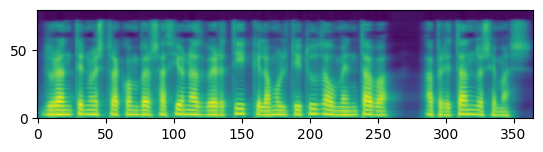

original audio


predicted audio


In [6]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))